# 筋電の周波数解析例

学籍番号：  
氏　　名：

## 0. 準備

□0-1. pandas，NumPy，matplotlibをインポートする。さらに線形回帰分析（相関分析）を行いたいので，`scipy.stats`を`stat`でインポートしておく。

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt

□0-2. データフレーム`df`に`'kinden-data.csv'`を読み込む：  
> `'kinden-data.csv'`はセンサのデータCSVファイルから筋電のみを取り出し，CSVファイルに書き出したファイルである。

In [2]:
df = pd.read_csv('kinden-data.csv')
df

,t,bi,tri
0,41196352,0,0
1,41196353,0,0
2,41196354,0,0
3,41196355,0,0
4,41196356,32767,-32768
...,...,...,...
343408,41539760,400,427
343409,41539761,382,442
343410,41539762,376,464
343411,41539763,365,465


□0-3. サンプリング周波数を`H`（=1000[Hz]）で定義しておく：

In [3]:
H = 1000

## 1. 筋電データ配列の作成

□1-1. dfにおいて，`'t'`は実験時刻[ms]，`'bi'`が二頭筋，`'tri'`が三頭筋の表面筋電圧（筋電とする）[mV]である。それぞれの筋電の1D-arrayを`bi`，`tri`としておく：

In [4]:
bi = np.array(df['bi'])  #二頭筋
tri=np.array(df['tri'])  #三頭筋

□1-2. `bi`と`tri`をプロットする。

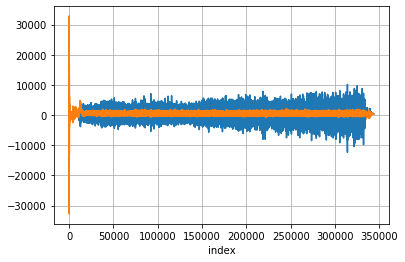

In [5]:
plt.plot(bi)
plt.plot(tri)
plt.xlabel('index')
plt.grid()

□1-3. 前方index0〜50000までをプロットしてみる。

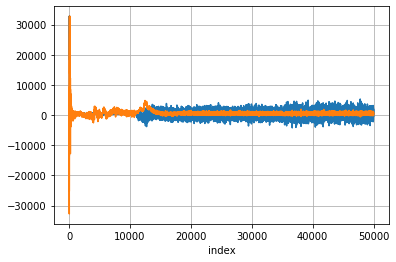

In [6]:
plt.plot(bi[:50000])
plt.plot(tri[:50000])
plt.xlabel('index')
plt.grid()

> index20000辺りからは確実に安定している。

□1-4. 後方index300000〜をプロットしてみる。

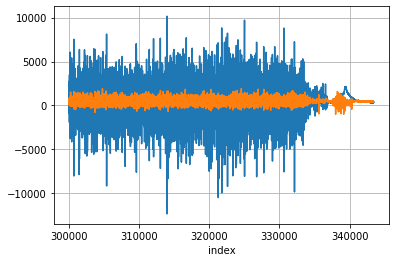

In [7]:
plt.plot(np.arange(len(bi))[300000:], bi[300000:])
plt.plot(np.arange(len(tri))[300000:],tri[300000:])
plt.xlabel('index')
plt.grid()

> index330000程度まで安定している。

□1-5. したがって，`bi`, `tri`をindex20000~330000まで切り取り，それらを再定義しておく：

In [8]:
bi = bi[20000:330000]
tri = tri[20000:330000]

□1-6. 再定義した `bi`, `tri `をプロットしてみる。

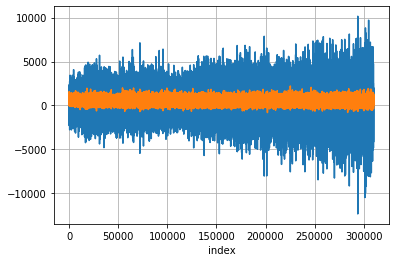

In [9]:
plt.plot(bi)
plt.plot(tri)
plt.xlabel('index')
plt.grid()

> 良さそうだ。これらの（再定義した）bi, triのndarrayでやっていこう。

□1-7. `bi`と`tri`の要素数（一致する）を確認しよう：

In [10]:
print(len(bi))
print(len(tri))

310000
310000


□1-8. 時間を区切って一定時間間隔のデータブロックをつくり，スペクトルの時間的変化をみていきたい。そうしてFFTを行うのだが，FFTは$2^n$個のデータに対して行うのだったし，このときのデータ数はサンプリング周波数の1000[Hz]以上でなければならなかった。  

そこで，とりあえず，$2^n$の値を各$n$について調べてみる(n=0,1,2,...20)：

In [11]:
for n in range(21):
    print(f'2の{n}乗：{2**n}')

2の0乗：1
2の1乗：2
2の2乗：4
2の3乗：8
2の4乗：16
2の5乗：32
2の6乗：64
2の7乗：128
2の8乗：256
2の9乗：512
2の10乗：1024
2の11乗：2048
2の12乗：4096
2の13乗：8192
2の14乗：16384
2の15乗：32768
2の16乗：65536
2の17乗：131072
2の18乗：262144
2の19乗：524288
2の20乗：1048576


□1-9. $2^{10}=1024$であることより，$n$は$10$以上でなければならない（サンプリング周波数が1000なので）。さて，**$n$が大きければ大きいほどFFTの周波数分解能は高くなるが，その代わり時間分解能は低くなる**ことに注意しよう（時間間隔のブロックの数が少なくなるからだ）。ということで，周波数分解能と時間分解能を天秤にかけて$n$を決めるんだ。  

そこで，$n$を10から増加させていったときのデータブロックの数を計算してみよう（データ要素数は`len(bi)`または`len(tri)`であることに注意）：

In [12]:
for n in range(10, 18):
    print(f'n={n}のときのブロック数：{len(bi)//2**n}')

n=10のときのブロック数：302
n=11のときのブロック数：151
n=12のときのブロック数：75
n=13のときのブロック数：37
n=14のときのブロック数：18
n=15のときのブロック数：9
n=16のときのブロック数：4
n=17のときのブロック数：2


> この結果から，自分たちの実験結果の解析のときの$n$の値を決定せよ。

□1-10. $n=12$で解析してみることにしよう。したがって，その時の各ブロックのデータ数`N`は4096個である。

In [13]:
N = 2**12
N

4096

□1-11. １つの間隔について`N`(=4096)データ，間隔数`len(bi)//N`(=75)だから，ndarray `bi`と`tri`の要素数を，間隔がきっちり収まるように再定義しておく（端数になる要素を切り捨てる）：

In [14]:
bi = bi[:N*(len(bi)//N)]
tri = tri[:N*(len(tri)//N)]

□1-12. `bi`または`tri`の要素数を確かめる：

In [15]:
len(bi)

307200

> 要素数は30720まで減った。

□1-13. 再再定義した bi, triをプロットしてみる。

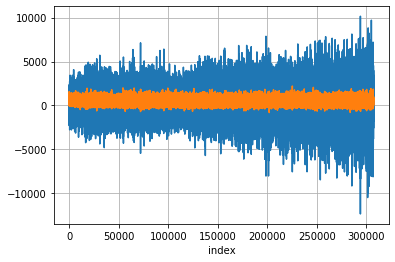

In [16]:
plt.plot(bi)
plt.plot(tri)
plt.xlabel('index')
plt.grid()

□1-14. `bi`, `tri`を`len(bi)//N`(=75)のブロックにわけ，それぞれ`lisbi`，`listri`に格納する。  
> **【公式1】**  
> 1D-ndarray `arr`を等間隔のブロックにわけるには：
> ```
> np.array_split(arr, ブロック数)
> ```
> を使う。戻り値はリストで，各リストの要素が分割された1D-ndarrayである（ <a href="https://note.nkmk.me/python-numpy-split/">NumPy配列ndarrayを分割（split, array_split, hsplit, vsplit, dsplit）</a> 参照）。  
> ※）`arr`の要素数がブロック数で割り切れない場合はエラーを出す。

In [17]:
lisbi = np.split(bi, len(bi)//N)
listri = np.split(tri, len(bi)//N)

> エラーが出なかったらちゃんと分割されている。

□1-15. リスト `lisbi`の要素数（分割されたブロック数）を`blocks`とし，その数を確認しておく。

In [18]:
blocks = len(lisbi)
blocks

75

> サブセクション1-9のとおり，75個の要素（１つの要素は1D-ndarrayである）がある。

## 2. 有効なパワーの1D-ndarrayの作成

□2-1. ここからは二頭筋のみで解説する。とりあえず1D-ndarray `lisbi`を10要素分表示してみる：

In [19]:
lisbi[:10]

[array([-642, -173,  407, ...,  332,  418,  723]),
 array([ 687,  111,  -68, ...,  573, 1057, 1326]),
 array([1291, 1003,  656, ..., -791, -668, -354]),
 array([  63,  292,  518, ..., -261, -205,  741]),
 array([1605, 1906, 1935, ..., -378, -573,  134]),
 array([716, 913, 938, ..., 120, 497, 431]),
 array([-448, -800, -953, ...,  344,  420,  943]),
 array([1259, 1366, 1530, ..., 1759, 1856, 1687]),
 array([1696, 1515,  891, ..., 2066, 1218, -247]),
 array([-1887, -2266, -2339, ...,  -170,   514,  1120])]

> 1D-ndarrayを要素にもつリストで，各要素の1D-ndarrayが筋電データで，それらが時間的に連続して格納されている。

□2-2. FFT周波数を`arrf`を求めておく：  
> index $k$のFFT周波数が$f_k=\frac{kH}{N}$であることを思い出せ。

In [20]:
arrf = np.arange(N)*H/N
arrf

array([0.00000000e+00, 2.44140625e-01, 4.88281250e-01, ...,
       9.99267578e+02, 9.99511719e+02, 9.99755859e+02])

□2-3. ナイキスト周波数は当然500(=H/2)[Hz]だが，1D-ndarray `arrf`のちょうど真ん中にある要素を取り出して確認してみる：

In [21]:
arrf[N//2]

500.0

> 500だ。もしそうでないなら，サブセクション2-2で実行したことが間違っている。

□2-4. 有効なFFT周波数は0Hzからナイキスト周波数未満の周波数であるから，この有効周波数の1D-ndarrayをarrf_effという変数名に格納しておこう：

In [22]:
arrf_eff = arrf[:N//2]
arrf_eff

array([0.00000000e+00, 2.44140625e-01, 4.88281250e-01, ...,
       4.99267578e+02, 4.99511719e+02, 4.99755859e+02])

□2-5. いよいよ二頭筋の筋電をFFTしてみる。リスト`lisbi`は，`N`(=4098)の要素をもった筋電配列(1D-array)が`blocks`(=75)個並んでいるリストであった。したがって，for文で`lisbi`から１つずつ1D-ndarrayの要素をとってきてFFT関数を作用させなければならないように思える。しかしながら，NumPyのFFT関数はユニバーサル関数になっている。  

**ユニバーサル関数**とは**リストやndarrayの全要素に対して，要素ごとに演算等の処理を行い，結果をndarrayで返す関数**である。したがって，`np.fft.fft`は`lisbi`に作用させたとき，`lisbi`の各々の要素の1D-ndarrayをFFT処理し，それらの結果を１つのndarrayでまとめて返すのである。  

`lis_bi`の要素をまとめてFFT処理した結果のndarrayを`arrF`に格納する：  
> ただし，この授業でのFFTの規約上，すべてのFFTの結果を`N`(=2$^{12}$=4098)で除しておくが，ここでの解析にはこのことは結果になにも影響を及ぼさないので，レポートにおける分析には`N`で除しておく必要はない。  
※）`/`演算（除演算）もユニバーサルである。

In [23]:
arrF = np.fft.fft( lisbi )/N

□2-6. `arrF`を表示してみる：

In [24]:
arrF

array([[ 3.56088379e+02 +0.j        , -7.31789957e+00+17.03083376j,
         4.41798560e-01 +6.11925059j, ...,  4.52924158e-01 -4.83509048j,
         4.41798560e-01 -6.11925059j, -7.31789957e+00-17.03083376j],
       [ 3.98126709e+02 +0.j        , -3.86276469e+00 -5.23421976j,
         1.06549766e-01 +2.52274365j, ...,  7.46088173e-02 +0.25349689j,
         1.06549766e-01 -2.52274365j, -3.86276469e+00 +5.23421976j],
       [ 3.98742920e+02 +0.j        , -2.51341204e+00 +0.08218702j,
        -4.43314794e-01 +4.71847414j, ..., -2.03451945e+00 -2.18312773j,
        -4.43314794e-01 -4.71847414j, -2.51341204e+00 -0.08218702j],
       ...,
       [ 3.95623535e+02 +0.j        ,  9.41284242e+00 +3.48295784j,
         9.59455571e-01 +3.03134869j, ..., -3.51620979e-01 -3.67174371j,
         9.59455571e-01 -3.03134869j,  9.41284242e+00 -3.48295784j],
       [ 4.03826416e+02 +0.j        , -2.16167493e+00 -1.38763524j,
        -8.18131681e+00 -5.19767374j, ..., -2.17932484e+00 -1.54343915j,
       

> すばらしい。ユニバーサル関数は強力だ。

□2-7. `arrF`のパワー`arrP`も求めておく：  
> ※）`np.abs`関数および`**`演算（累乗演算）もユニバーサルである。

In [25]:
arrP = np.abs(arrF)**2

□2-8. まずは全てのパワー（`arrP`の全ての要素）をプロットし，パワーがどのような形状になるかを確かめてみる。ただし，周波数0Hzのときのパワー（非常におおきな値を示すであろうが，それは装置に依存するバイアス値であろうから解析に無意味）と，ナイキスト周波数以上のパワーを除去しておく：

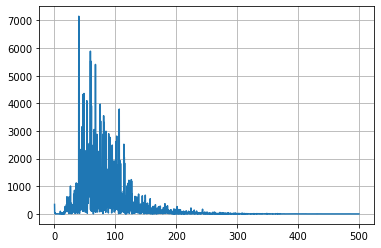

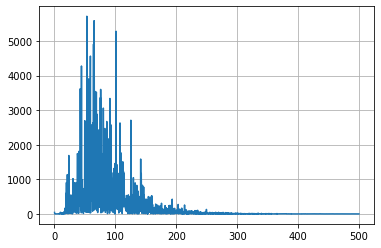

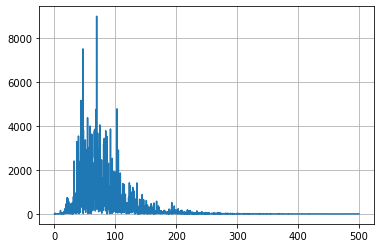

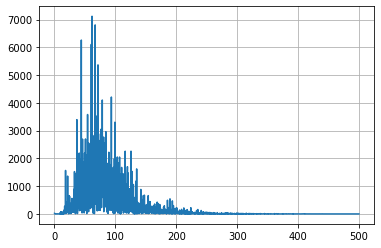

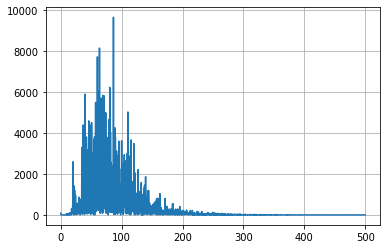

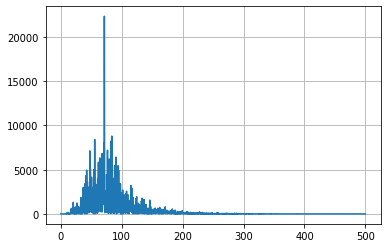

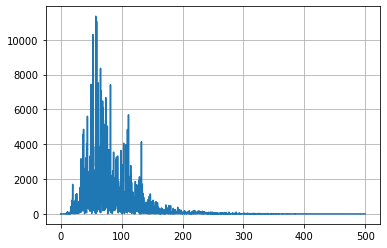

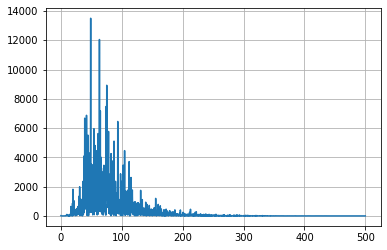

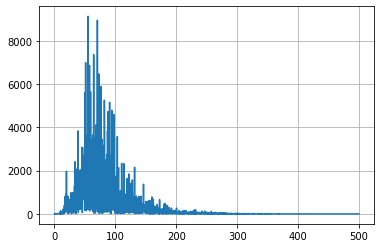

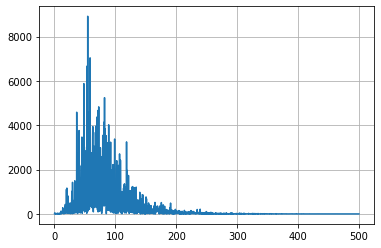

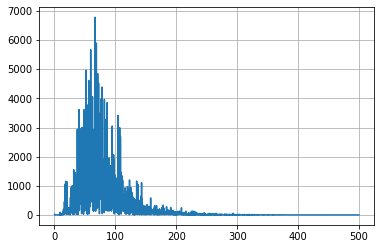

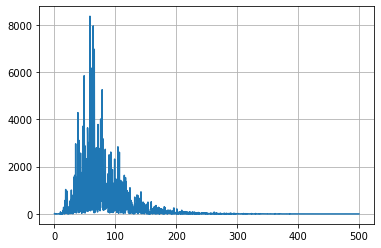

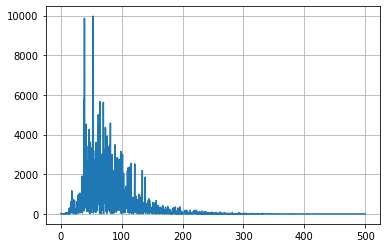

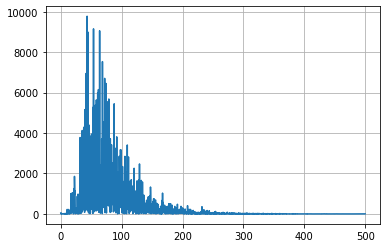

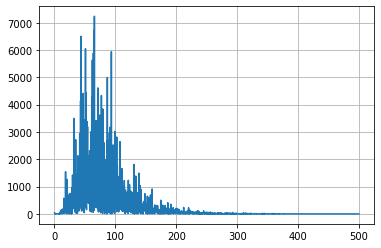

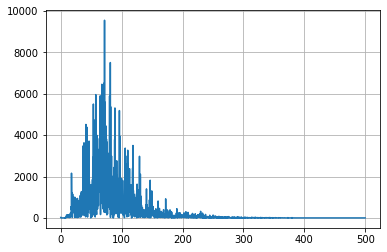

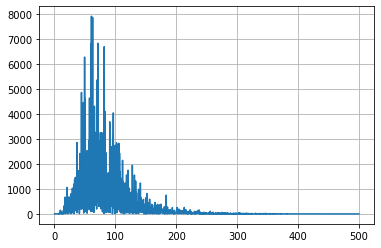

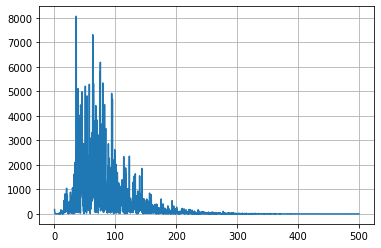

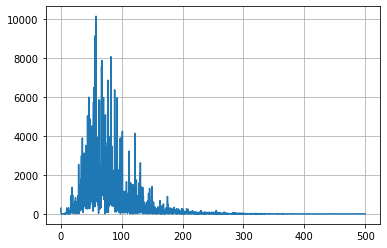

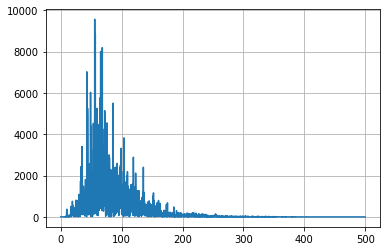

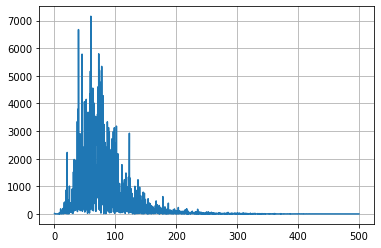

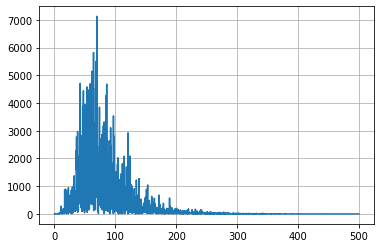

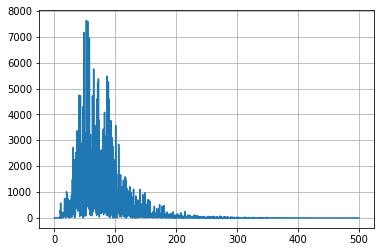

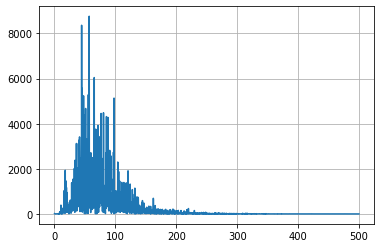

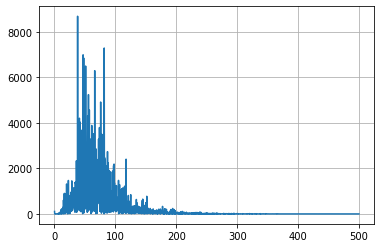

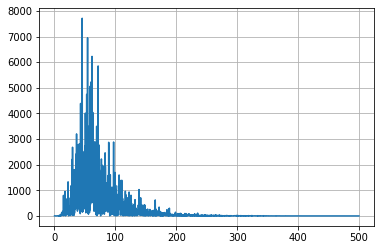

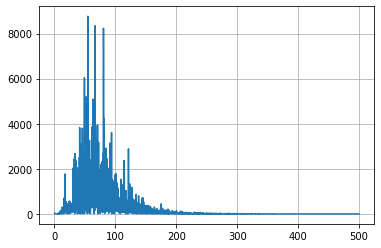

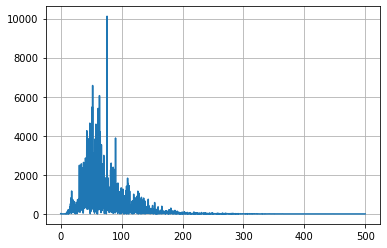

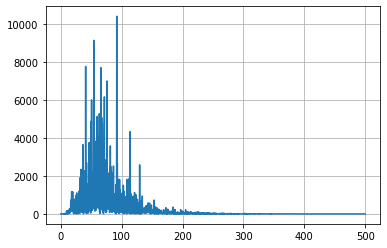

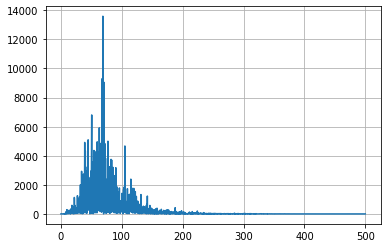

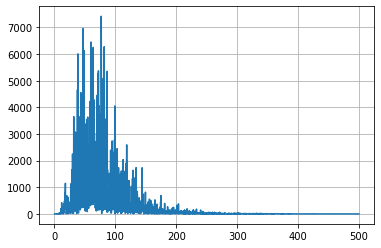

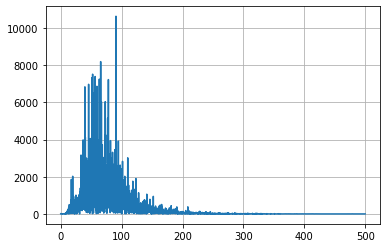

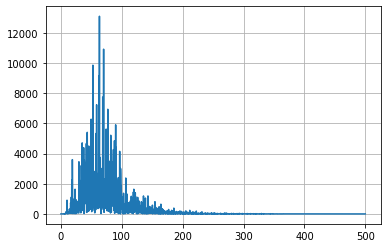

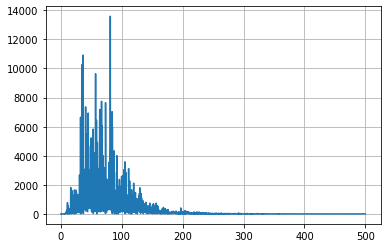

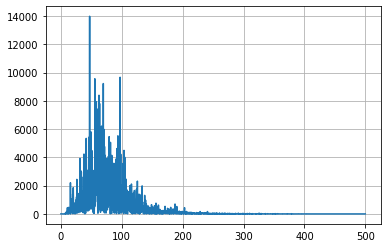

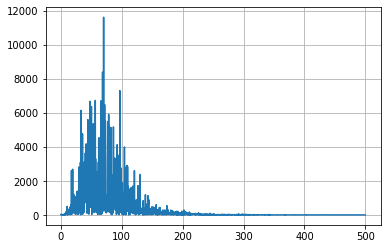

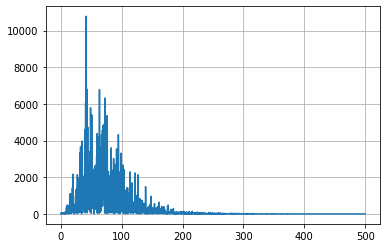

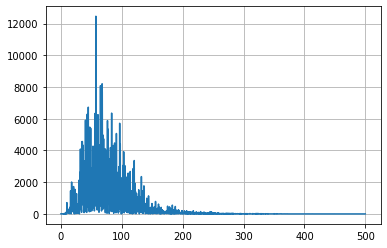

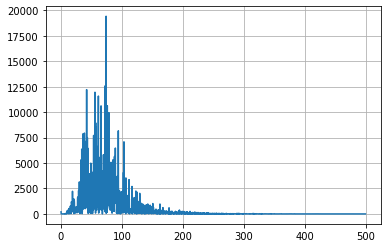

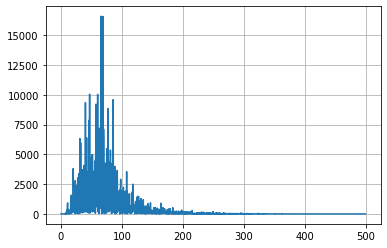

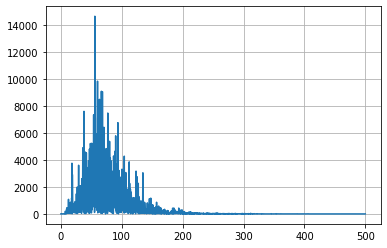

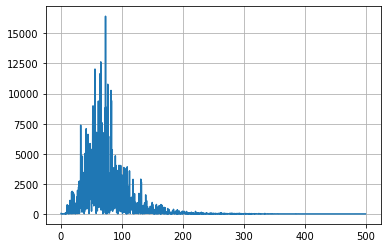

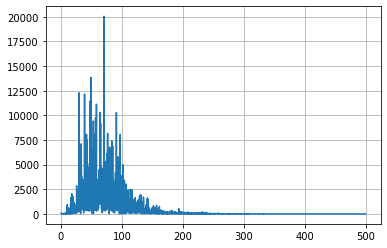

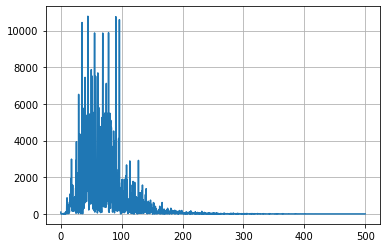

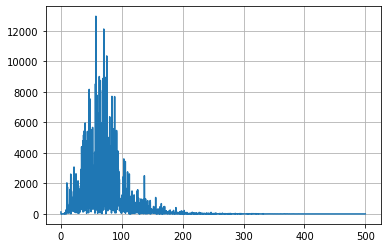

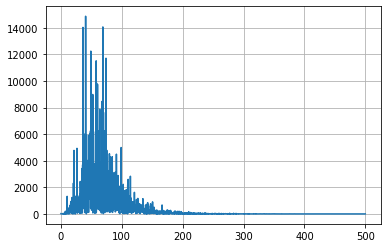

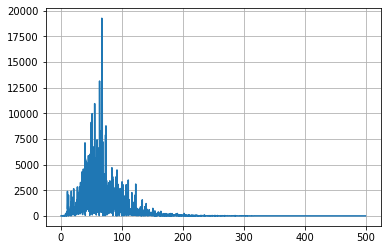

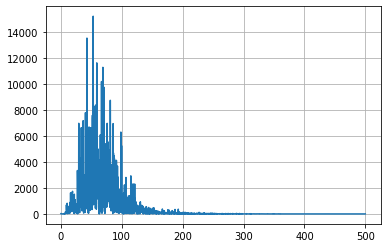

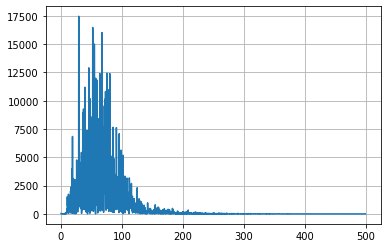

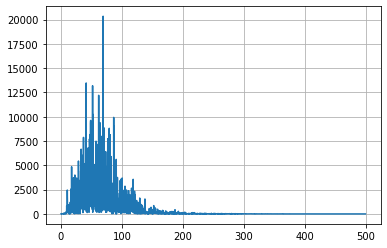

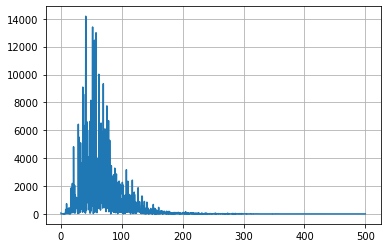

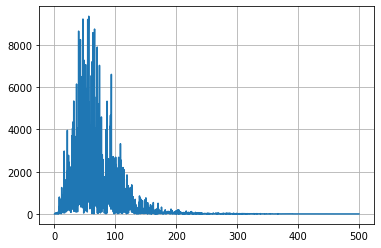

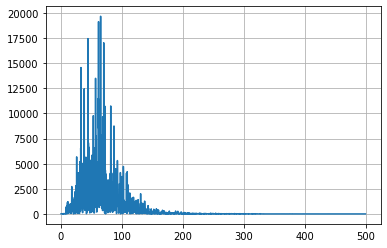

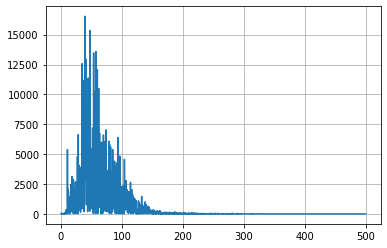

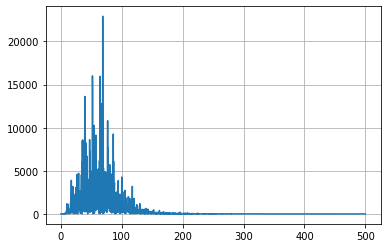

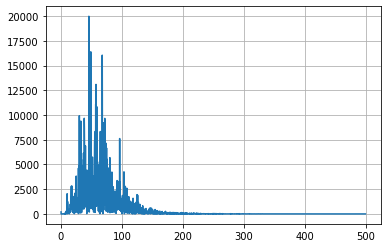

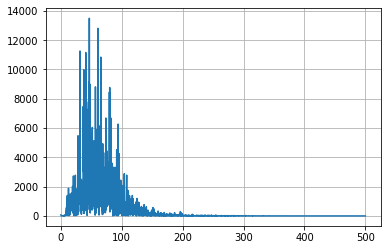

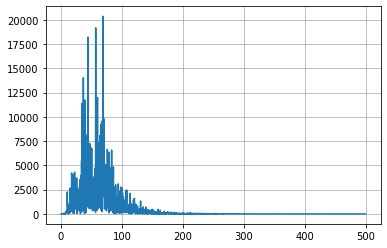

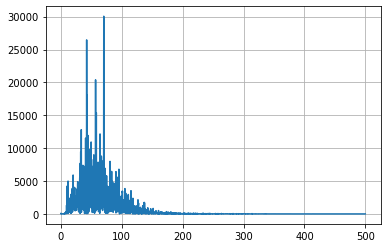

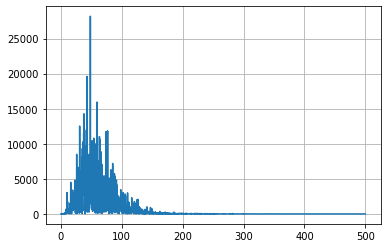

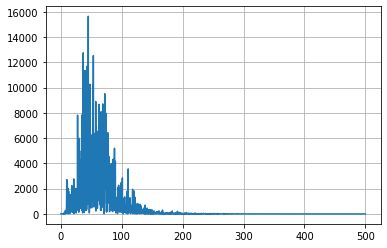

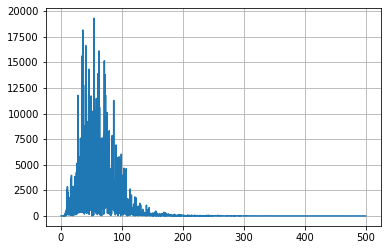

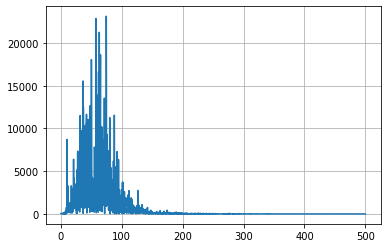

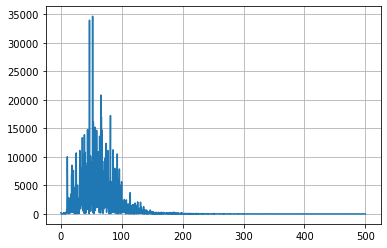

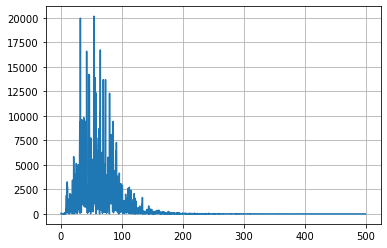

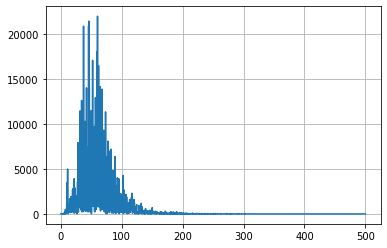

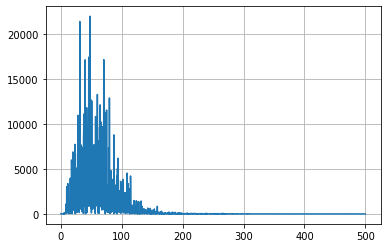

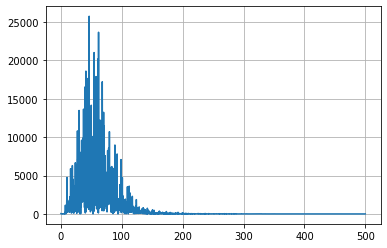

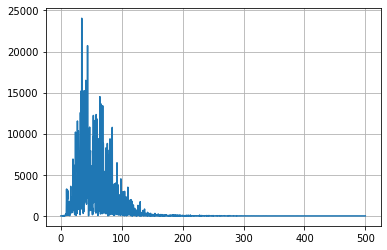

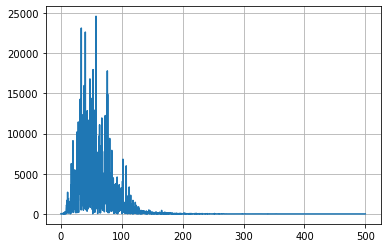

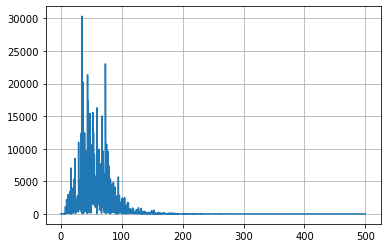

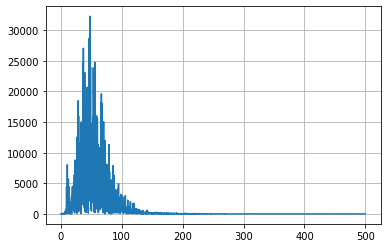

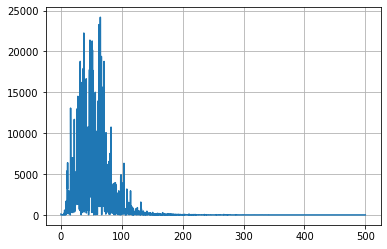

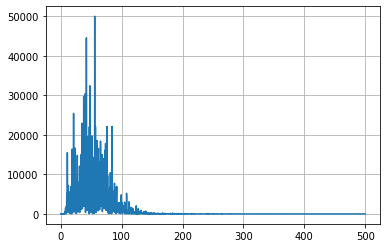

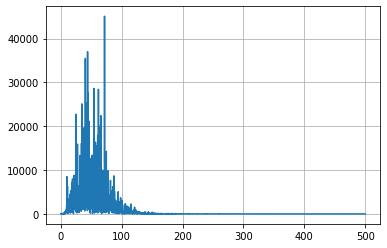

In [26]:
for _ in arrP:
    plt.plot(arrf[1:N//2], _[1:N//2])
    plt.grid()
    plt.show()

□2-9. 低周波数（例えば0~5Hzとしておこう）でのパワーは，多分，皮膚の伸長・短縮による電極間距離の振動など，力学的な要因によって引き起こされるの電圧変化からくるものと考えられる（0Hzはバイアス）。他方，高周波数（例えば300Hz以上としておこう）でのパワーは，デバイスのノイズによって引き起こされるものと考えられる。したがって，5Hz以上300Hz以下のパワーを有効パワーとして，それ以外の周波数のパワーを除去したい。  

そこでまず，$f_k=\frac{kH}{N} \rightarrow k=\frac{f_k N}{H}$の関係より，5Hzと300Hz近傍のインデックス（$k$）を求め，それらをそれぞれ`k5`, `k300`という変数に格納しておき，それらを表示しよう：

In [27]:
k5 = 5 * N // H
k300 = 300 * N // H
print(f'k5={k5}, k300={k300}')

k5=20, k300=1228


□2-10. セクション2-9のように，有効なパワーは`k2`(=20)インデックス（の周波数）〜`k300`(=1228)インデックス（に対応する周波数）までである。そこで，パワーのセット`arrP`から有効なパワーのセット`arrP_eff`を次のように作成しよう：  
1. `arrP`のナイキスト成分までのコピーを`arrP_eff`につくる。  
> `arrP_eff = arrP[:, :N//2].copy()`とする。こうしなければ，`arrP_eff`を変更させたときに`arrP`も変更されてしまう（<a href="https://note.nkmk.me/python-numpy-view-copy-shares-memory/">NumPy配列ndarrayがビューかコピーか、メモリを共有しているか判定</a> 参照）。
2. `arrP_eff`の各要素（各パワーの1D-ndarray）の最初〜`k5`インデックスまでの要素を0にする。
3. `arrP_eff`の各要素（各パワーの1D-ndarray）の`k300`インデックス〜最後までの要素を0にする。

In [28]:
arrP_eff = arrP[:, :N//2].copy()
arrP_eff[:, :k5] = 0
arrP_eff[:, k300:] = 0

□2-12. まずは全ての有効パワー（`arrP/eff`の全ての要素）をプロットしてみる：

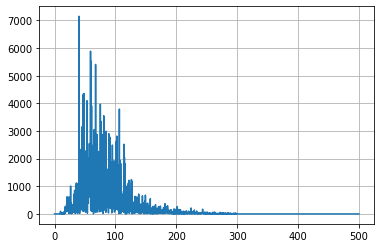

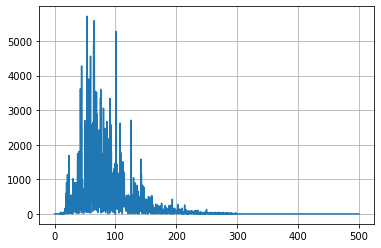

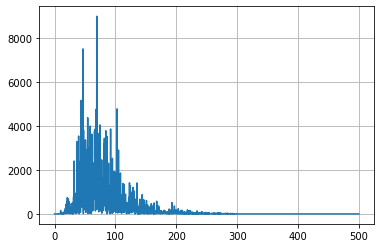

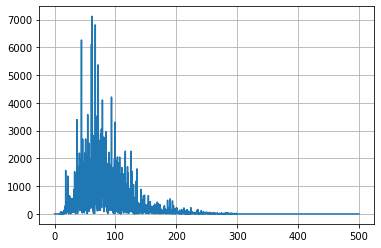

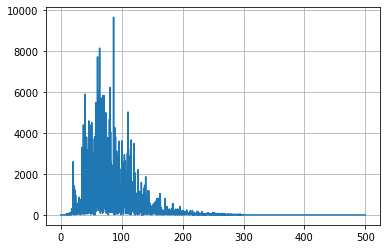

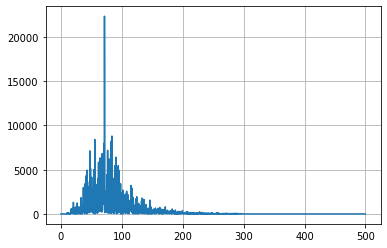

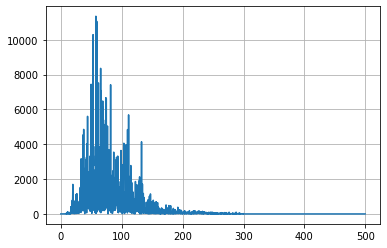

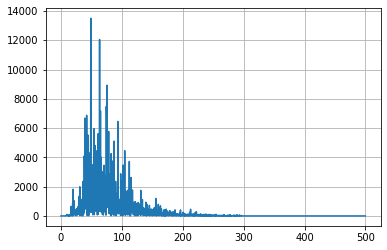

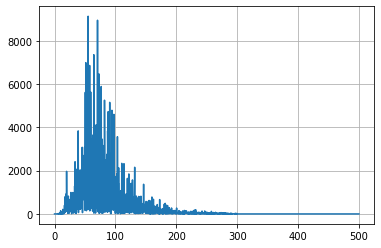

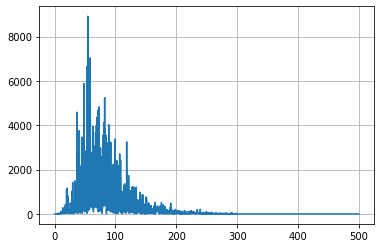

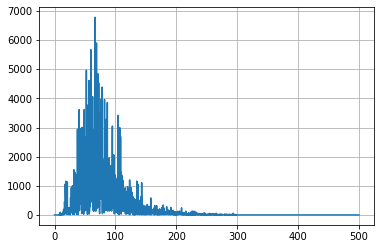

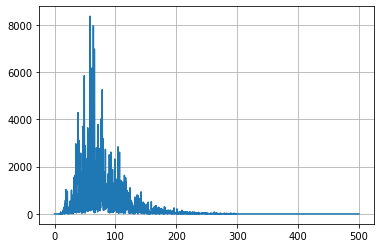

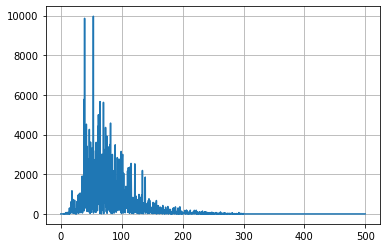

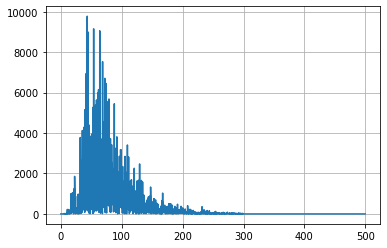

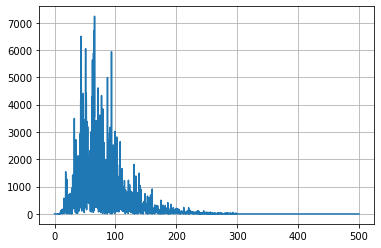

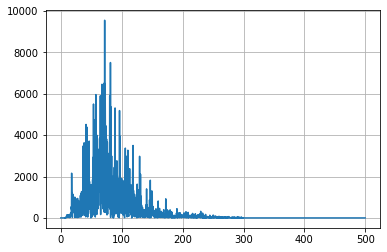

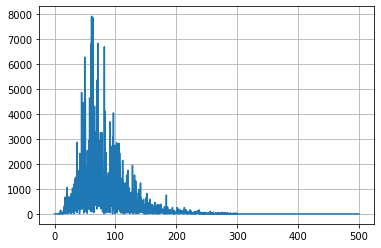

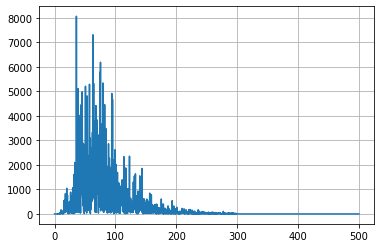

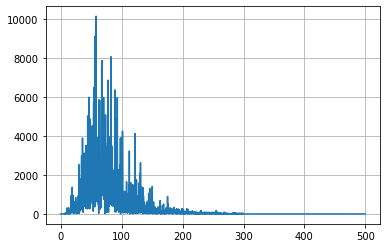

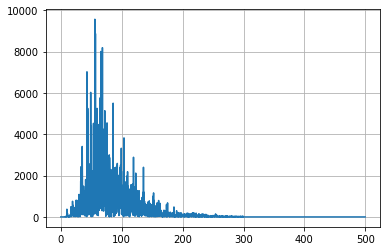

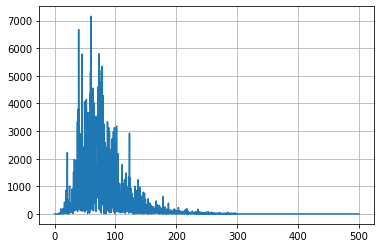

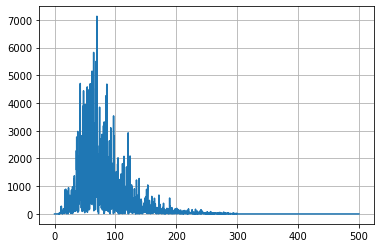

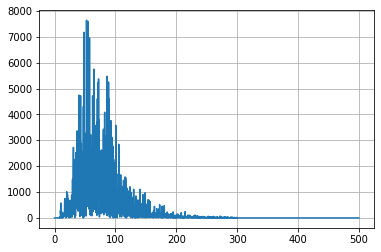

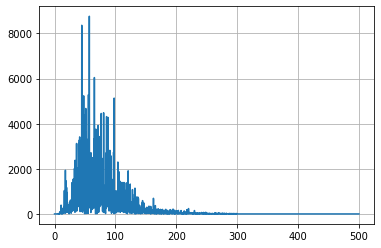

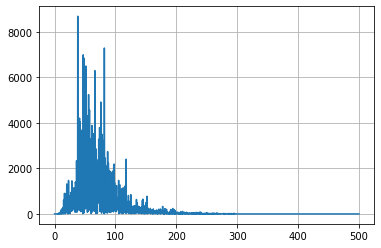

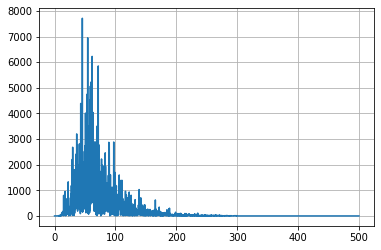

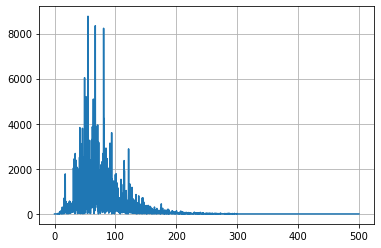

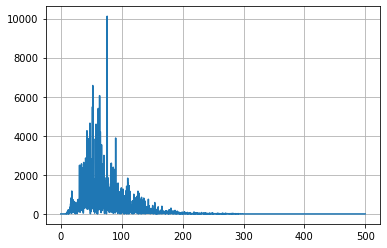

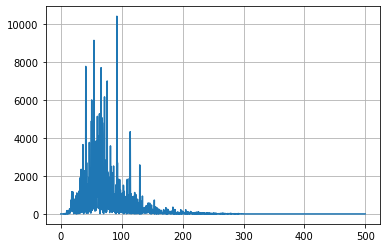

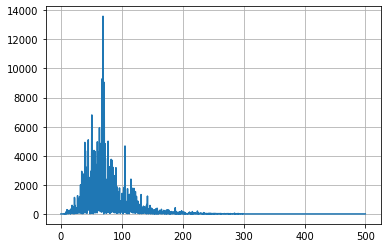

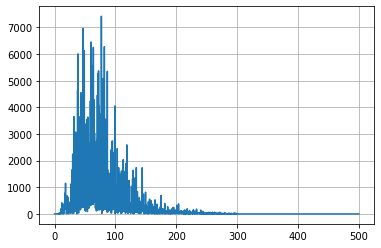

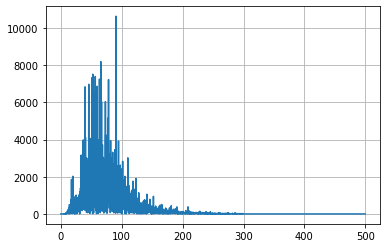

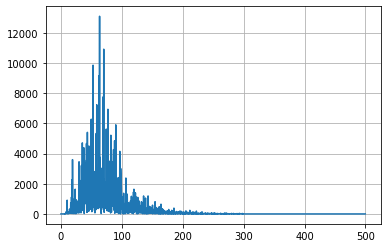

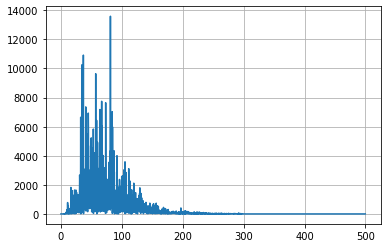

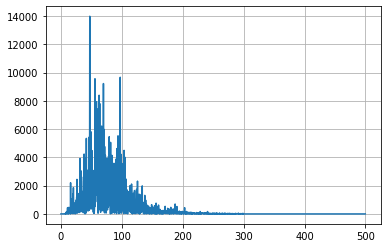

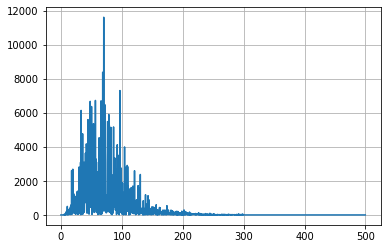

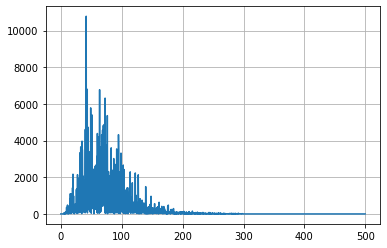

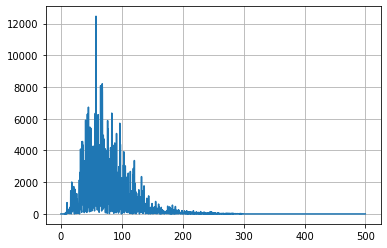

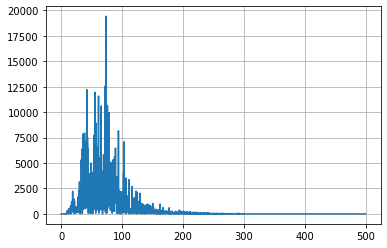

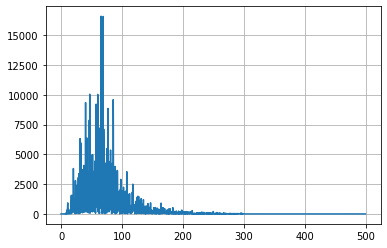

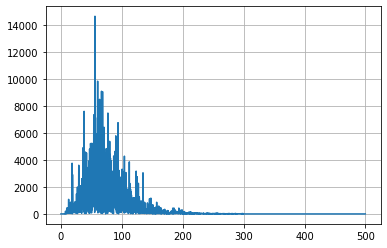

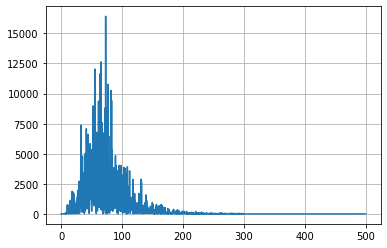

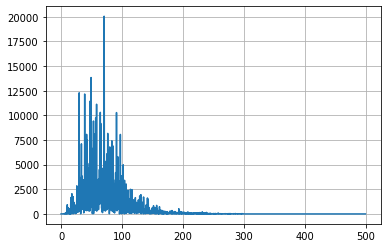

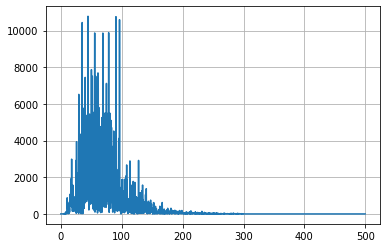

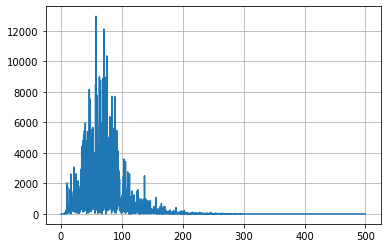

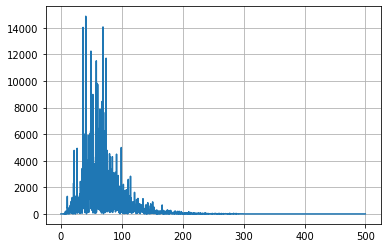

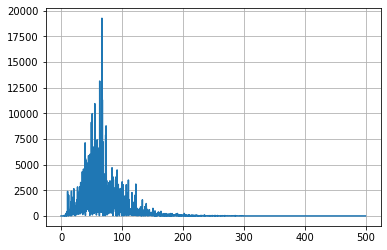

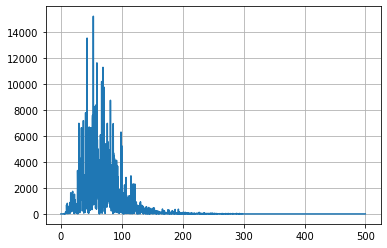

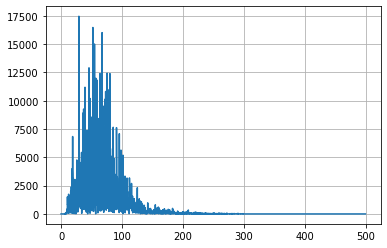

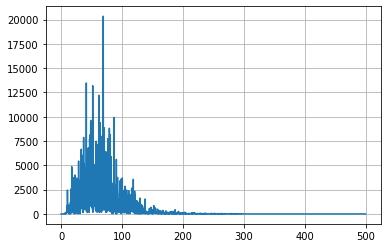

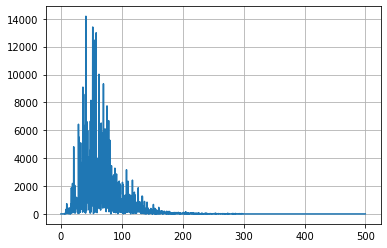

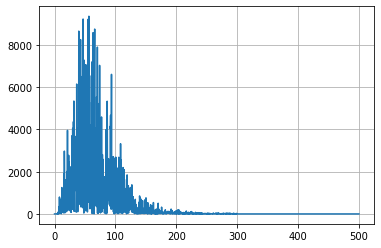

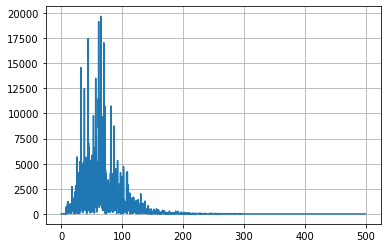

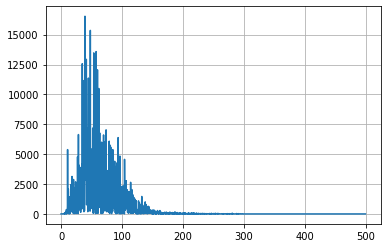

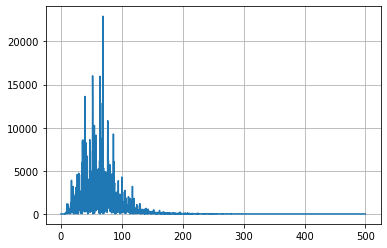

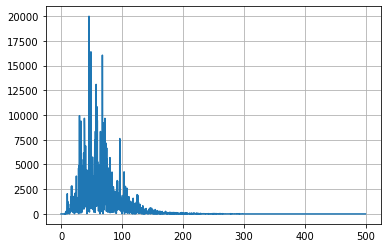

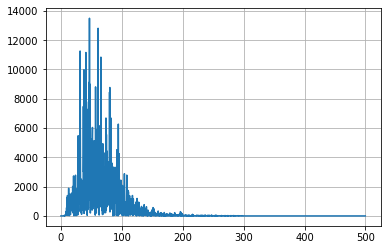

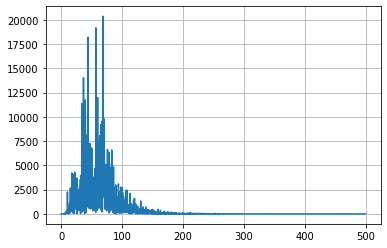

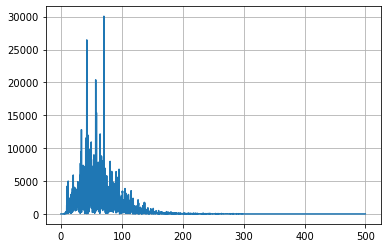

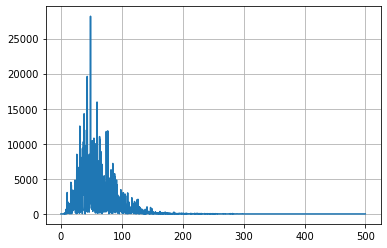

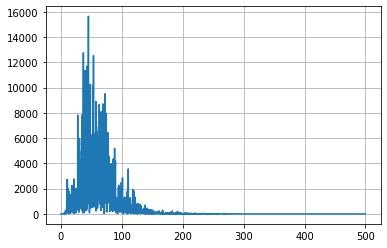

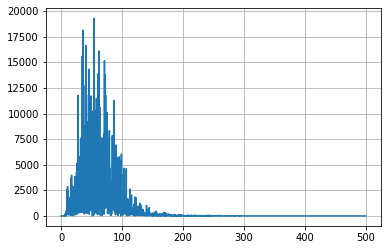

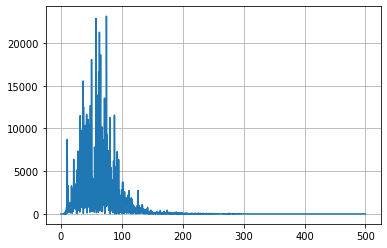

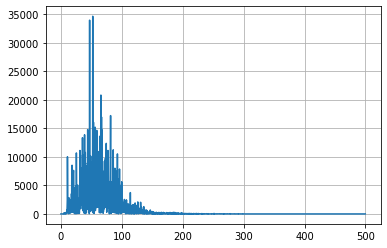

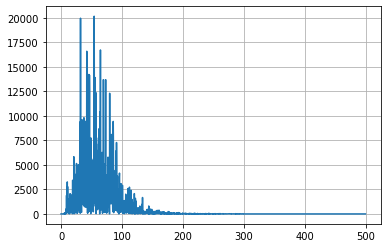

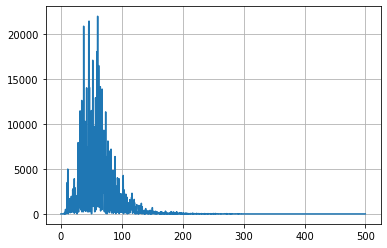

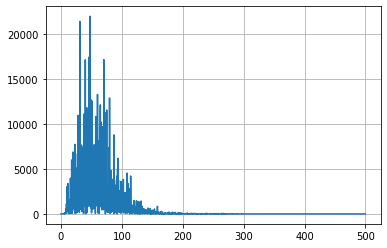

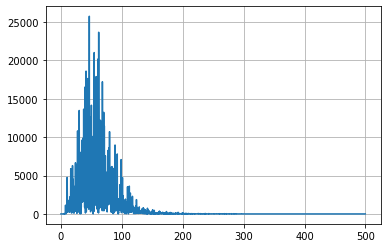

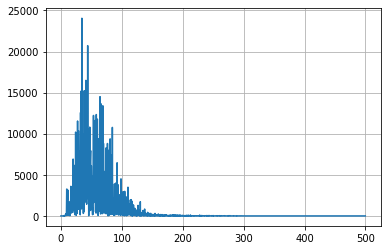

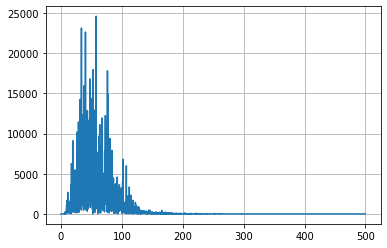

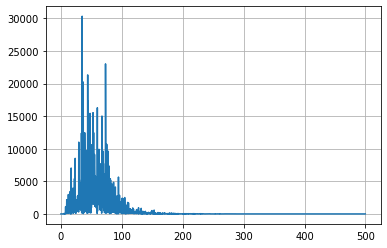

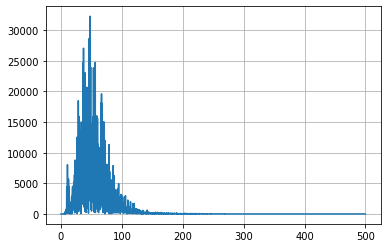

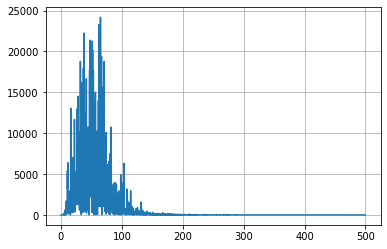

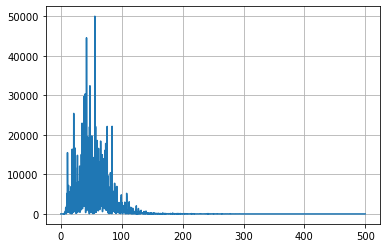

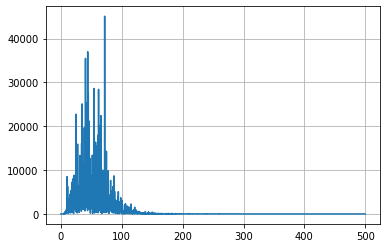

In [29]:
for _ in arrP_eff:
    plt.plot(arrf_eff, _)
    plt.grid()
    plt.show()

> これでいいだろう。

## 3. 平均パワーの時間的変化

□3-1. 各実験時間ブロックの有効パワーの平均値を`arrP_mean`に格納しよう（教科書p.131参照）：

In [30]:
arrP_mean = np.mean(arrP_eff, axis=1)
arrP_mean

array([ 203.9441519 ,  203.9078468 ,  224.37747924,  230.75185258,
        304.49661892,  336.58740043,  348.0403415 ,  300.28183332,
        269.86048898,  263.82913312,  230.83075946,  217.69613353,
        252.7314838 ,  320.30565993,  247.6332176 ,  311.57328254,
        246.96244698,  279.3674288 ,  333.76174329,  285.09501842,
        257.566245  ,  255.98080057,  272.27370565,  244.61440964,
        237.80539565,  212.41840287,  215.43182929,  204.81270222,
        240.56788339,  261.55950693,  277.42047937,  294.01018162,
        309.93390675,  334.99101049,  371.03042111,  321.80459082,
        284.5124644 ,  349.22227118,  432.91622127,  391.15576239,
        391.175939  ,  448.20446865,  466.12204569,  409.39498165,
        398.67548294,  380.77798953,  388.95783158,  404.03782969,
        577.50324245,  471.0887922 ,  390.27557281,  400.88173364,
        504.99076428,  462.5227916 ,  442.57028689,  456.9476351 ,
        416.18190595,  484.61602425,  612.21544735,  587.87776

□3-2. １実験時間ブロックは`N`(=4098)[ms]で，セクション1-15より，これが`blocks`(=75)個連なる。そこで各時間ブロックを代表する時刻を各々の**中間時刻**で定め，それを`arrt_mid`という変数に定義しておく：
> 0から始まる`blocks`(=75)個の1ずつ増加する1D-ndarrayをつくり，それに`N/H`(=4.096)[s]を乗じたものに，`N/(2*H)`(=2.048)[s]を加算しておけばよい。

In [31]:
arrt_mid = np.arange(blocks)*N/H + N/(2*H)
arrt_mid

array([  2.048,   6.144,  10.24 ,  14.336,  18.432,  22.528,  26.624,
        30.72 ,  34.816,  38.912,  43.008,  47.104,  51.2  ,  55.296,
        59.392,  63.488,  67.584,  71.68 ,  75.776,  79.872,  83.968,
        88.064,  92.16 ,  96.256, 100.352, 104.448, 108.544, 112.64 ,
       116.736, 120.832, 124.928, 129.024, 133.12 , 137.216, 141.312,
       145.408, 149.504, 153.6  , 157.696, 161.792, 165.888, 169.984,
       174.08 , 178.176, 182.272, 186.368, 190.464, 194.56 , 198.656,
       202.752, 206.848, 210.944, 215.04 , 219.136, 223.232, 227.328,
       231.424, 235.52 , 239.616, 243.712, 247.808, 251.904, 256.   ,
       260.096, 264.192, 268.288, 272.384, 276.48 , 280.576, 284.672,
       288.768, 292.864, 296.96 , 301.056, 305.152])

□3-3. `arrt_mid`と`arrP_mean`の散布図を描いてみる：

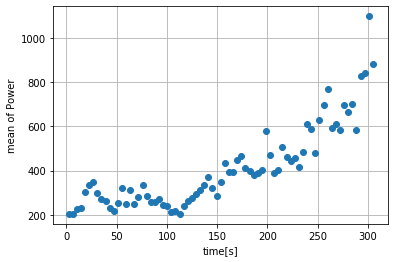

In [32]:
plt.plot(arrt_mid, arrP_mean, 'o')
plt.xlabel('time[s]')
plt.ylabel('mean of Power')
plt.grid()

> 上のグラフをじーっと見ていると，指数関数的に増加しているような気がする。

□3-4. そこで，`arrP_mean`の対数をとって，それを`arrLogP_mean`という変数に格納する。つまり，$\bar{P}_\mathrm{eff}=e^{at+b}$なら$\log{\bar{P}_\mathrm{eff}}=at+b$という１次式で書けるということを利用する。ここで，$\bar{P}_\mathrm{eff}$は平均パワー，$t$は時間（中間時刻），$a$と$b$は定数である。  
> **【公式1】**1D-ndarray `arr`に対して，
> ```
> np.log(arr)
> ```
> は，`arr`の自然対数を返す。`np.log`関数はユニバーサルである。

In [33]:
arrLogP_mean = np.log(arrP_mean)

□3-5.  `arrt_mid`と`arrP_mean`の散布図を描いてみる：

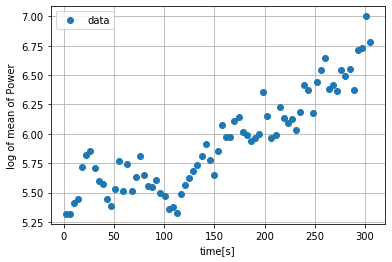

In [34]:
plt.plot(arrt_mid, arrLogP_mean, 'o')
plt.xlabel('time[s]')
plt.ylabel('log of mean of Power')
plt.legend(['data', 'fitting curve'])
plt.grid()

□3-4. 上の散布図にフィットする直線の方程式がどうなるのかを求めてみる。これは$y=ax+b$なる１次方程式の係数$a,b$を，**最小二乗法**$^*$というやり方で求めるやりかただ。  
> $^*$簡単にいうと，データ`arr1`(=$x$)と`arr2`(=$y$)があり，それらの間に$y=ax+b$という関係の予測曲線(直線)をあてはめたとき，**曲線からデータの外れの２乗を最小にする**ように，１次方程式の未定係数$a$，$b$を定める方法である。

ここで今の場合，$x$には1D-ndarray`arrt_mid`が，$y$には1D-ndarray`arrLogP_mean`が入る。NumPyではこれを求める関数がある。 
> ***
> **【公式2】**  1D-ndarrayデータ`arr1`を$x$，1D-ndarrayデータ`arr2`を$y$とするとき，
> ```
> np.polyfit(arr1, arr2, 1)
>```
> は１次関数$y=ax+b$の係数$a$，$b$を1D-ndarrayで返す。   
>***

早速やってみよう：  
> 1. `np.polyfit`関数を用いて，変数$x$に対応にする$t$(=`arrt_mid`)と変数$y$に対応する$\log{\bar{P}_\mathrm{eff}}$(=`arrLogP_mean`)が１次関数$y=a_1x+b_1$にフィットするように係数$a_1$(=`a1`)，$b_1$(=`b1`)を決定する。
> 2. 1D-ndarray `arrt_mid`を独立変数$x$に対応するデータとし，上記1で決定された係数`a1`，`b1`を用いて従属変数$y$に対応する1D-ndarray `arrLogP_fit`をつくる。
> 3. `a1`，`b1`を
> ```
> a1=..., b1=...
> ```
>という形式で表示する。

In [35]:
a1, b1 = np.polyfit(arrt_mid, arrLogP_mean, 1)
arrLogP_fit = a1 * arrt_mid + b1
print(f'a1={a1}, b1={b1}')

a1=0.004140350631334375, b1=5.296865129071069


□3-5. 上で求めた直線を，セクション3-3の散布図の中に描いてみよう：
> - 図のサイズは`(8, 6)`
> - `arrt_mid`と`arrLogP_mean`の間の関係は青い点
> - `arrt_mid`と`arrLogP_fit`の間の関係は赤の曲線
> - x軸ラベルは`'t[sec]'`
> - y軸ラベルは`'log of mean of Power'`
> - 凡例は`['data', 'fitting line']`
> - グリッド線を引く

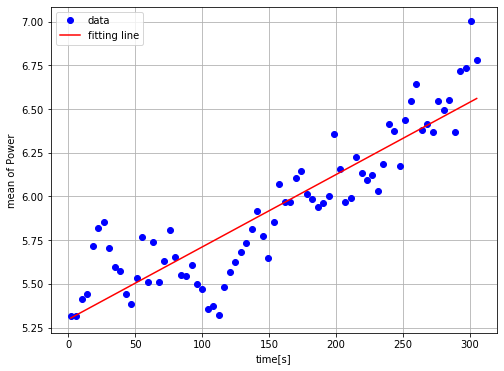

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(arrt_mid, arrLogP_mean, 'o', c='blue')
plt.plot(arrt_mid, arrLogP_fit, c='red')
plt.xlabel('time[s]')
plt.ylabel('mean of Power')
plt.legend(['data', 'fitting line'])
plt.grid()

> ばっちり直線に沿っている。これで，相関係数が求められる。

□3-6. $t$(=`arrt_mid`)と$\log{\bar{P}_\mathrm{eff}}$(=`arrLogP_mean`)に相関があるかどうかを調べよう。  
> **【公式3】** データ1D-ndarray `arr1`と`arr2`の間に相関があるかどうかを調べるには，
```
stat.pearsonr(arr1, arr2)
```
> とする。戻り値はタプルで与えられ，それのインデックス0の要素は**相関係数**を与え，インデックス1の要素は$p$値を与える。$p$値が0.05未満のときのみ`arr1`と`arr2`相関が認められ（相関係数が無意味でない），相関係数による相関の目安は表１のようになる。

<center>表１．相関係数と相関の目安</center>

|相関係数の値|目安|
|:---:|:---:|
|[0.7, 1]|強い正の相関|
|[0.4, 0.7)|正の相関|
|[0.2, 0.4)|弱い正の相関|
|(-0.2, 0.2)|相関なし|
|(-0.4, -0.2]|弱い負の相関|
|(-0.7, -0.4]|負の相関|
|[-1.0, -0.7]|強い負の相関|

> なお，$p$値は，次の仮説が起こりうる確率を算出する：
>
> 相関関係の**帰無仮説**…データ`arr1`とデータ`arr2`の間に相関はない。

In [37]:
stat.pearsonr(arrt_mid, arrLogP_mean)

(0.8942273652263317, 3.40253225932388e-27)

> $p<0.05$なので相関が認められ，相関係数から$t$(=`arrt_mid`)と$\log{\bar{P}_\mathrm{eff}}$(=`arrLogP_mean`)の間に強い正の相関が認められる。これは，**$t$(=`arrt_mid`)と$\bar{P}_\mathrm{eff}$(=`arrP_mean`)の間にも強い正の相関が認められる**ことを示している。

## 4. 平均パワー周波数の時間的変化

**平均パワー周波数（mean power frequency：MPF）$f_\mathrm{MP}$**は，有効なパワーの平均における周波数である。パワーの重心（の周波数）を求めるようなもので，次の式で与えられる：
$$
f_\mathrm{MP}=\frac{\sum_k{f_k P_k}}{\sum_k{P_k}} \tag{4-1}
$$
ここで，$k$は有効な周波数番号である。このセクションでは，各時間ブロックの平均パワー周波数をもとめ，それの時間的変化と相関関係を求める。

□4-1. 式(4-1)の左辺$f_\mathrm{MP}$を`arrf_MP`という変数に格納しよう：  
> 1. (4-1)の右辺の分母は`arrP_eff`の各要素の総和からなる1D-ndarray（教科書p.128参照）。
> 2. (4-1)の右辺の分子は`arrf_eff`と`arrP_eff`のアダマール積（教科書p.107参照）の1D-ndarrayの各要素の総和からなる1D-ndarray。
> 3. (4-1)の右辺は上記1を上記2で（アダマール的に）除した1D-ndarray（教科書p.107参照）。

In [38]:
arrf_MP = np.sum(arrf_eff * arrP_eff, axis=1) / np.sum(arrP_eff, axis=1)
arrf_MP

array([83.63276345, 84.41780626, 82.60659794, 84.29012525, 84.29595616,
       84.57644083, 81.44020628, 80.54482942, 82.72743867, 82.90646902,
       80.13840744, 78.57450441, 81.28848807, 81.51622188, 81.11395627,
       84.00742045, 83.62303249, 80.76570242, 79.69261706, 82.73350732,
       79.06315639, 80.83023461, 77.83176042, 76.28693149, 71.62305383,
       72.63796528, 76.49306569, 74.06057584, 75.84272287, 76.2987456 ,
       77.63995323, 76.89792804, 74.81490995, 75.35972149, 77.91866846,
       74.69201579, 73.2345734 , 78.1873989 , 74.97055734, 73.64340836,
       75.50996665, 74.83511104, 73.75443288, 71.29561408, 71.16064017,
       69.91364693, 69.34073499, 68.17801227, 67.96967706, 68.37697113,
       65.90481545, 67.87724219, 67.80342935, 64.65176946, 64.89091615,
       65.54799378, 65.01684876, 63.04315263, 64.23126503, 61.75244357,
       61.87108271, 62.01689141, 62.2424979 , 62.58838811, 61.34187371,
       61.60561902, 61.71792407, 60.35545951, 57.6895223 , 57.57

□4-2. ここでもセクション3-2で定義した中間時刻`tarr_mid`を時間$t$として使うことにする。  

$t$(=`arrt_mid`)と$f_\mathrm{MP}$(=`arrf_MP`)の散布図を描いてみる：

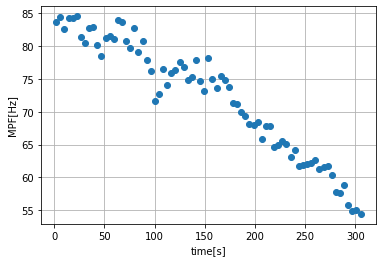

In [39]:
plt.plot(arrt_mid, arrf_MP, 'o')
plt.xlabel('time[s]')
plt.ylabel('MPF[Hz]')
plt.grid()

> 直線的に減少しているようだ。

□4-3. セクション4-2のグラフから，$t$(=`arrt_mid`)と$f_\mathrm{MP}$(=`arrf_MP`)にフィットする直線の方程式を求めてみる。  

$t$(=`arrt_mid`)を$x$，$f_\mathrm{MP}$(=`arrP_MP`)を$y$とし，直線$y=a_2x+b_2$の$a_2$に対応する変数を`a2`，$b_2$に対応する変数を`b2`として，`a2`，`b2`を公式2にしたがって求めよう：

In [40]:
a2, b2 = np.polyfit(arrt_mid, arrf_MP, 1)
print(f'a2={a2}, b2={b2}')

a2=-0.09538786520252816, b2=86.81308090197805


□4-4. `a2 * arrt_mid + b2`によって与えれる値の1D-ndarrayを変数`arrf_fit`に格納する： 

In [41]:
arrf_fit = a2 * arrt_mid + b2

□4-5. 上で求めた直線を，セクション4-2の散布図の中に描いてみよう：
> - 図のサイズは`(8, 6)`
> - `arrt_mid`と`arrf_MP`の間の関係は青い点
> - `arrt_mid`と`arrf_fit`の間の関係は赤の曲線
> - x軸ラベルは`'t[sec]'`
> - y軸ラベルは`'mean power frequency'`
> - 凡例は`['data', 'fitting line']`
> - グリッド線を引く

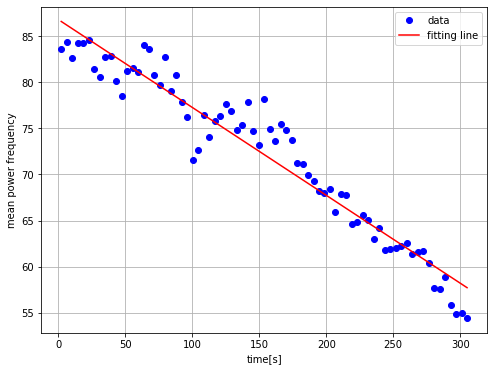

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(arrt_mid, arrf_MP, 'o', c='blue')
plt.plot(arrt_mid, arrf_fit, c='red')
plt.xlabel('time[s]')
plt.ylabel('mean power frequency')
plt.legend(['data', 'fitting line'])
plt.grid()

> すばらしい！ データ点がほぼ完全にフィッティング直線に沿っている。

□4-6. セクション3-6と同様に，$t$(=`arrt_mid`)と$f_\mathrm{MP}$(=`arrf_MP`)のあいだの相関関係を調べてみよう：

In [43]:
stat.pearsonr(arrt_mid, arrf_MP)

(-0.9661640812177791, 1.053770291761562e-44)

□4-7. セクション4-6の結果を下のマークダウン セルに述べよ。

（ここをダブルクリックして記述）